In [5]:
from dotenv import load_dotenv
load_dotenv()

True

In [173]:
from typing import Dict, Literal, cast,Annotated
from typing_extensions import List,TypedDict
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph,END,START
from langchain_core.documents import Document
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools import TavilySearchResults

In [174]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone
from langchain_cohere import CohereEmbeddings
from langchain import hub
from langgraph.types import Command
from langchain_cohere import ChatCohere
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

In [175]:
pc = Pinecone()
index_name = "react-demo"

index = pc.Index(index_name)

embeddings = CohereEmbeddings(model="embed-english-v3.0")
vector_store = PineconeVectorStore(embedding=embeddings, index=index)

prompt = hub.pull("rlm/rag-prompt")

In [176]:
from langchain_community.tools import TavilySearchResults,tool

search = TavilySearchResults(
    max_results=5,
)
tools = [search]

In [177]:
from datetime import datetime

def get_current_time() -> str:
    """
    use this tool to get the current time
    Returns the current time as a string in the format hh:mm:ss.
    """
    return datetime.now().strftime("%H:%M:%S")


In [178]:

def get_current_date() -> str:
    """
    use this tool to get the current date
    Returns the current date as a string in the format YYYY-MM-DD.
    """
    return datetime.now().strftime("%Y-%m-%d")


In [179]:
get_current_date()

'2025-01-03'

In [342]:
class State(TypedDict):
    messages:Annotated[list,add_messages]
    isRetrieved:bool
# Define application steps
def react_retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["messages"][0].content,k=3)
    state["isRetrieved"] = True
    return {"messages": retrieved_docs}

llm_with_tools = llm.bind_tools(tools=[search])

def generate(state: State):
    print("hello")
    if "isRetrieved" in  state.keys():
        docs_content = "\n\n".join(doc.page_content for doc in state["messages"][1:]) 
        messages = prompt.invoke({"question": state["messages"][0], "context": docs_content})
    else:
        messages = prompt.invoke({"question": state["messages"][0], "context": "No context available"})
    response = llm_with_tools.invoke(messages)
    state["isRetrieved"] = False
    return {"messages": response}


In [343]:
from langgraph.prebuilt import ToolNode
tools_node = ToolNode(tools)

In [344]:
llm = ChatCohere(model="command-r-plus-08-2024")

embeddings = CohereEmbeddings(model="embed-english-v3.0")

In [345]:
from typing import Literal
from langchain.prompts import PromptTemplate
from langgraph.types import Command
import ast

# Create a LangChain prompt template with escaped curly braces
template = """

Analyze the user's question and determine whether it requires updated documentation knowledge. Follow these guidelines:

1. If the question is about a new feature or recent update in React, return: {{"retrieve":"true"}}

2. If the question is related to React basics, foundational concepts, or general usage, return: {{"retrieve":"false"}}

Question: {question}

Your Answer:
"""

react_doc_analysis_prompt = PromptTemplate(
    input_variables=["question"],
    template=template,
)

prompt_analysis_chain = react_doc_analysis_prompt | llm

In [346]:
def evaluator(state: State) ->Command[Literal['react_retrieve','generate']]:
    result = prompt_analysis_chain.invoke({"question":state["messages"]}).content
    result = ast.literal_eval(result)
    if result['retrieve'] == 'true':
    
        return Command(
            goto="react_retrieve"
        )
    return Command(
        goto="generate"
    )


In [347]:
memory = MemorySaver()

In [348]:
graph_builder = StateGraph(State).add_sequence([react_retrieve,generate])
graph_builder.add_node(evaluator)
graph_builder.add_edge(START, "evaluator")
graph_builder.add_node("tools",tools_node)
graph_builder.add_conditional_edges(
    'generate',
    tools_condition,
    {"tools":"tools",END:END}
)
graph_builder.add_edge("tools","generate")
graph = graph_builder.compile(checkpointer=memory)

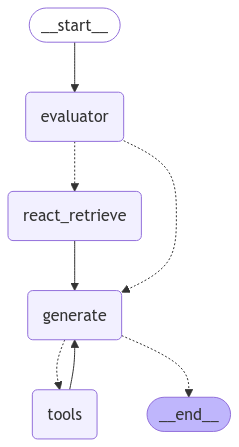

In [349]:
graph

In [350]:
config = {"configurable": {"thread_id": "1"}}

In [352]:
user_input = "what is new update in react in 2025?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is new update in react in 2025?


TooManyRequestsError: status_code: 429, body: data=None message="You are using a Trial key, which is limited to 1000 API calls / month. You can continue to use the Trial key for free or upgrade to a Production key with higher rate limits at 'https://dashboard.cohere.com/api-keys'. Contact us on 'https://discord.gg/XW44jPfYJu' or email us at support@cohere.com with any questions"